## https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)


In [3]:
# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<MkldnnRnnLayerBackward0>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward0>))


## Example: An LSTM for Part-of-Speech Tagging

In [ ]:
## skip

# NOTE: the output of LSTM seq length is same as the input seq length 

# Long Short Term Memory (LSTM) RNN Pytorch

## https://medium.com/@prudhvirajnitjsr/long-short-term-memory-lstm-rnn-pytorch-892ceba08d32

In [22]:
import torch
import torch.nn as nn
import string

data = "i love neural networks"
EOF = "#"
#data = data+EOF
data = data.lower()

seq_len = len(data)

letters = string.ascii_lowercase+' #'
print('Letter set is '+letters)
n_letters = len(letters)
print(n_letters)

Letter set is abcdefghijklmnopqrstuvwxyz #
abcdefghijklmnopqrstuvwxyz #


In [29]:
n_letters

28

In [23]:

def ltt(ch):
    ans = torch.zeros(n_letters)
    ans[letters.find(ch)]=1
    return ans
    
def getLine(s):
    ans = []
    for c in s:
        ans.append(ltt(c))
    return torch.cat(ans,dim=0).view(len(s),1,n_letters)
    
class MyLSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(MyLSTM,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        #LSTM takes, input_dim, hidden_dim and num_layers incase of stacked LSTMs
        self.LSTM = nn.LSTM(input_dim,hidden_dim)
        self.LNN = nn.Linear(hidden_dim,input_dim)
        
    #Input must be 3 dimensional (seq_len, batch, input_dim). 
    #hc is a tuple of hidden and cell state vector. Each of them have shape (1,1,hidden_dim)
    def forward(self,inp,hc):
        #this gives outut for each input in the sequence and also (hidden and cell state vector)
        #Dimensions of output vector is (seq_len,batch,hidden_dim)
        output,_= self.LSTM(inp,hc)
        return self.LNN(output)
        #return output

In [24]:
#Dimensions of output of neural network is (seq_len, batch , hidden_dim). Since we want output dimensions to be
#the same as n_letters, hidden_dim = n_letters (**output dimensions = hidden_dimensions)
hidden_dim = n_letters     
#Invoking model. Input dimensions = n_letters i.e 28. output dimensions = hidden_dimensions = 28
model = MyLSTM(n_letters,hidden_dim)
#I'm using Adam optimizer here
optimizer = torch.optim.Adam(params = model.parameters(),lr=0.01)
#Loss function is CrossEntropyLoss
LOSS = torch.nn.CrossEntropyLoss()

#List to store targets
targets = []
#Iterate through all chars in the sequence, starting from second letter. Since output for 1st letter is the 2nd letter
for x in data[1:]+'#':
    #Find the target index. For a, it is 0, For 'b' it is 1 etc..
    targets.append(letters.find(x))
#Convert into tensor
targets = torch.tensor(targets)
    
n_iters = 400

#List to store input
inpl = []
#Iterate through all inputs in the sequence
for c in data:
    #Convert into tensor
    inpl.append(ltt(c))
#Convert list to tensor
inp = torch.cat(inpl,dim=0)
#Reshape tensor into 3 dimensions (sequence length, batches = 1, dimensions = n_letters (28))
inp = inp.view(seq_len,1,n_letters)

In [28]:
inp.shape

torch.Size([22, 1, 28])

In [30]:
targets

tensor([26, 11, 14, 21,  4, 26, 13,  4, 20, 17,  0, 11, 26, 13,  4, 19, 22, 14,
        17, 10, 18, 27])

In [25]:
#Let's note down start time to track the training time
import time
start = time.time()
#Number of iterations
n_iters = 150
for itr in range(n_iters):
    #Zero the previosus gradients
    model.zero_grad()
    optimizer.zero_grad()
    #Initialize h and c vectors
    h = torch.rand(hidden_dim).view(1,1,hidden_dim)
    c = torch.rand(hidden_dim).view(1,1,hidden_dim)
    #Find the output
    output = model(inp,(h,c))
    #Reshape the output to 2 dimensions. This is done, so that we can compare with target and get loss
    output = output.view(seq_len,n_letters)
    #Find loss
    loss = LOSS(output,targets)
    #Print loss for every 10th iteration
    if itr%10==0:
        print('Iteration : '+str(itr)+' Loss : '+str(loss) )
    #Back propagate the loss
    loss.backward()
    #Perform weight updation
    optimizer.step()
    
print('Time taken to train : '+str(time.time()-start)+" seconds")

Iteration : 0 Loss : tensor(3.3275, grad_fn=<NllLossBackward0>)
Iteration : 10 Loss : tensor(2.5152, grad_fn=<NllLossBackward0>)
Iteration : 20 Loss : tensor(2.1348, grad_fn=<NllLossBackward0>)
Iteration : 30 Loss : tensor(1.7366, grad_fn=<NllLossBackward0>)
Iteration : 40 Loss : tensor(1.2629, grad_fn=<NllLossBackward0>)
Iteration : 50 Loss : tensor(0.8741, grad_fn=<NllLossBackward0>)
Iteration : 60 Loss : tensor(0.5489, grad_fn=<NllLossBackward0>)
Iteration : 70 Loss : tensor(0.3019, grad_fn=<NllLossBackward0>)
Iteration : 80 Loss : tensor(0.1631, grad_fn=<NllLossBackward0>)
Iteration : 90 Loss : tensor(0.0914, grad_fn=<NllLossBackward0>)
Iteration : 100 Loss : tensor(0.0565, grad_fn=<NllLossBackward0>)
Iteration : 110 Loss : tensor(0.0437, grad_fn=<NllLossBackward0>)
Iteration : 120 Loss : tensor(0.0309, grad_fn=<NllLossBackward0>)
Iteration : 130 Loss : tensor(0.0252, grad_fn=<NllLossBackward0>)
Iteration : 140 Loss : tensor(0.0206, grad_fn=<NllLossBackward0>)
Time taken to train :

In [26]:
#This utility method predicts the next letter given the sequence   
def predict(s):
    #Get the vector for input
    inp = getLine(s)
    #Initialize h and c vectors
    h = torch.rand(1,1,hidden_dim)
    c = torch.rand(1,1,hidden_dim)
    #Get the output
    out = model(inp,(h,c))
    #Find the corresponding letter from the output
    return letters[out[-1][0].topk(1)[1].detach().numpy().item()]
         

#THis method recursively generates the sequence using the trained model
def gen(s):
    #If generated sequence length is too large, or terminate char is generated, we can print the generated output so far
    if s[-1]=='#' or len(s)>=len(data)+5:
        print(s)
        return
    #Predict with sequence s
    pred = predict(s)
    #Continue prediction with sequence s + predicted value
    print(s+pred)
    #Recurse
    gen(s+pred)

## LSTM for Time Series Prediction in PyTorch

# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

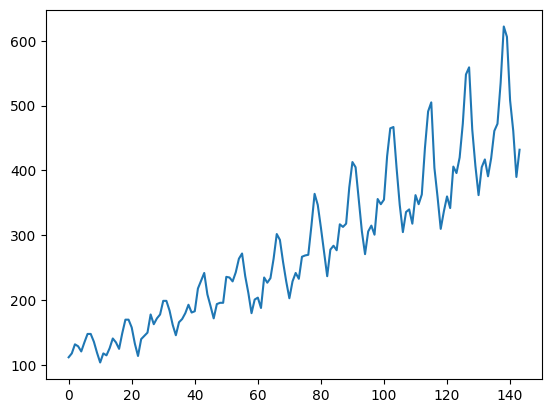

In [32]:
plt.plot(timeseries)
plt.show()

In [33]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [34]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [35]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

Epoch 0: train RMSE 225.9390, test RMSE 425.1898
Epoch 100: train RMSE 179.5303, test RMSE 376.5283
Epoch 200: train RMSE 142.5920, test RMSE 336.2139
Epoch 300: train RMSE 112.9092, test RMSE 301.1601
Epoch 400: train RMSE 90.3007, test RMSE 269.9909
Epoch 500: train RMSE 68.6825, test RMSE 237.3153
Epoch 600: train RMSE 53.3769, test RMSE 208.3255
Epoch 700: train RMSE 42.7385, test RMSE 183.9696
Epoch 800: train RMSE 35.6377, test RMSE 162.9989
Epoch 900: train RMSE 30.5638, test RMSE 144.9002
Epoch 1000: train RMSE 27.2104, test RMSE 129.7256
Epoch 1100: train RMSE 24.9228, test RMSE 117.4553
Epoch 1200: train RMSE 23.5235, test RMSE 107.2157
Epoch 1300: train RMSE 22.3208, test RMSE 99.6820
Epoch 1400: train RMSE 21.6738, test RMSE 93.7785
Epoch 1500: train RMSE 20.8232, test RMSE 88.9970
Epoch 1600: train RMSE 20.2144, test RMSE 85.7034
Epoch 1700: train RMSE 19.8528, test RMSE 82.4276
Epoch 1800: train RMSE 19.5383, test RMSE 80.5477
Epoch 1900: train RMSE 19.3955, test RMSE 78.

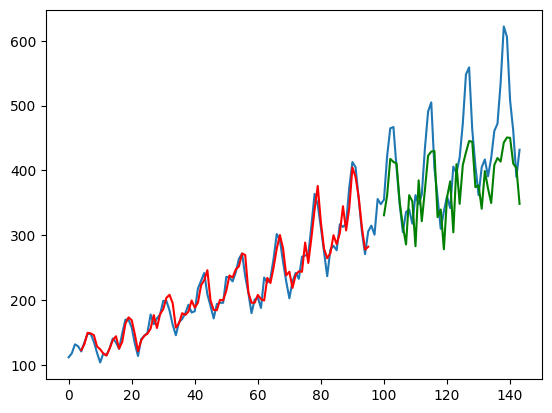

In [36]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()